In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
import numpy as np
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.segmentation import fcn_resnet50
from tqdm.notebook import tqdm
import cv2
import os
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import time
import math
from skimage import io, color
import matplotlib.pyplot as plt


In [3]:
#function for calculating IoU, precision and recall between two masks

def IoU(result1,result2):
    
    result1 = result1>0.5
    result2 = result2>0.5

    contours1, hierarchy = cv2.findContours(result1.astype("uint8")*255, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours2, hierarchy = cv2.findContours(result2.astype("uint8")*255, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    intersection = np.logical_and(result1, result2)
    contoursi, hierarchy = cv2.findContours(intersection.astype("uint8")*255, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    union = np.logical_or(result1, result2)
    iou_score = np.sum(intersection) / np.sum(union)
    
    if(len(contours1)>0):
        precision = len(contoursi)/len(contours1)
    else:
        precision = 0
    if(len(contours2)>0):
        recall = len(contoursi)/len(contours2)
    else:
        recall = 0
    
    if(recall > 1):
        recall = 1
    if(precision > 1):
        precision = 1

  
    return iou_score, precision, recall

In [4]:
#definition of our dataset. Returns duos of normalized image + its segmentation mask

class EarDataset(Dataset):
    """Ear dataset."""

    def __init__(self, root_dir, transform=None, isValidation=False):

        img_dir = "train"
        annot_dir = "trainannot"
        if(isValidation):
            img_dir = "test"
            annot_dir = "testannot"
        
        self.data_img = []
        self.data_annot = []
        for img in os.listdir(root_dir + "/" + img_dir):
            if(img.split(".")[-1]=="png"):
                self.data_img.append(root_dir + "/" + img_dir + "/" + img)
        for img in os.listdir(root_dir + "/" + annot_dir):
            if(img.split(".")[-1]=="png"):
                self.data_annot.append(root_dir + "/" + annot_dir + "/" + img)


    def __len__(self):
        return len(self.data_img)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = io.imread(self.data_img[idx])
        #print(image.dtype)
        annot = io.imread(self.data_annot[idx])*255
        
        if len(image.shape) == 2:
            image = image = color.gray2rgb(image)
        elif image.shape[2] == 4:
            image = image[:,:,:3]
    
        image = image_transform(image)
        annot = annot_transform(annot)
        
        return image, annot

In [5]:
#our transforms from image to tensor

image_transform = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
annot_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(1),
        transforms.ToTensor()
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [6]:
#creating our dataset from images from given folder

path = "AWEForSegmentation"

datasetTrain = EarDataset(root_dir=path, isValidation=False)
datasetValid = EarDataset(root_dir=path, isValidation=True)


dataset_loader_train = torch.utils.data.DataLoader(datasetTrain,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)
dataset_loader_valid = torch.utils.data.DataLoader(datasetValid,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)
print(len(dataset_loader_train))


188


In [7]:
#used to graph our losses

losses_train = []
losses_valid = []

In [8]:
#our training function. Runs training and validation for the given number of epochs. If validation=true, it will 
#skip the training part and only validate the model on the test set. The checkpoint with the highest IoU is saved
#to a file to load later

def train_model(model, criterion, optimizer, num_epochs=2, validation=False):
    since = time.time()

    highest_iou = 0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                if validation:
                    continue
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            print("Starting phase: ", phase)
                
            running_loss = 0.0
            running_iou = 0.0
            running_p = 0.0
            running_r = 0.0

            # Iterate over data.
            dataload = dataset_loader_train if phase == 'train' else dataset_loader_valid
            for j, stuff in enumerate(tqdm(dataload)):
                
                images, annots = stuff
                
                images = images.cuda()
                annots = annots.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)["out"]
                    loss = criterion(outputs, annots)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() #* images.size(0)
                #print('Runnning loss: {}'.format(running_loss))
                #running_corrects += torch.sum(preds == labels.data)
                pred_iou = 0.0
                for i in range(outputs.shape[0]):
                    pred = (outputs[i].cpu().sigmoid().detach().permute(1,2,0).numpy())[:,:,0]
                    ann = annots[i].cpu().detach().permute(1,2,0).numpy()[:,:,0]
                    iou,p,r = IoU(ann,pred)
                    running_iou += iou
                    running_p += p
                    running_r += r
                    
                #running_iou += pred_iou/outputs.shape[0]
                
                #print(running_iou/(j+1),j)
                
            epoch_loss = running_loss / len(dataload.dataset)
            epoch_iou = running_iou / len(dataload.dataset)
            epoch_p = running_p / len(dataload.dataset)
            epoch_r = running_r / len(dataload.dataset)
            if(phase == 'train'):
                losses_train.append(epoch_loss)
            else:
                losses_valid.append(epoch_loss)
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Iou: {:.4f} precision:{:.4f} recall:{:.4f}'.format(
                phase, epoch_loss, epoch_iou, epoch_p, epoch_r))
        
        if(epoch_iou > highest_iou):
            highest_iou = epoch_iou
            torch.save(net.state_dict(), 'checkpoint_fcn.pth')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))

    return model

This part is for training of the model:

In [8]:
#Creating our network and loading the weights from a ResNet pretrained od ImageNet

net = fcn_resnet50(pretrained = False, num_classes = 1)
net = net.cuda()

net_pretrained = torchvision.models.resnet50(pretrained=True)

criterion = nn.BCEWithLogitsLoss().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.0005)

pretrained_dict_pre = net_pretrained.state_dict()
model_dict = net.state_dict()

pretrained_dict = {}
for k in pretrained_dict_pre:
    pretrained_dict["backbone."+k]=pretrained_dict_pre[k]
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. load the new state dict
net.load_state_dict(pretrained_dict, strict = False)
#print(next(net.parameters())[0])

_IncompatibleKeys(missing_keys=['classifier.0.weight', 'classifier.1.weight', 'classifier.1.bias', 'classifier.1.running_mean', 'classifier.1.running_var', 'classifier.4.weight', 'classifier.4.bias'], unexpected_keys=[])

In [10]:
#running the training for 15 epochs

#criterion = nn.BCEWithLogitsLoss().cuda()
#optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.0005)

net = net.cuda()
net = train_model(net, criterion, optimizer, num_epochs=15)

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 0/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0304 Iou: 0.5835 precision:0.9353 recall:0.7717
Starting phase:  val


100%|██████████| 63/63 [00:09<00:00,  6.74it/s]


val Loss: 0.0095 Iou: 0.6964 precision:0.9860 recall:0.8633


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0062 Iou: 0.7825 precision:0.9880 recall:0.9449
Starting phase:  val


100%|██████████| 63/63 [00:09<00:00,  6.86it/s]


val Loss: 0.0049 Iou: 0.7696 precision:0.9860 recall:0.9500


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0036 Iou: 0.8291 precision:0.9933 recall:0.9733
Starting phase:  val


100%|██████████| 63/63 [00:09<00:00,  6.84it/s]


val Loss: 0.0033 Iou: 0.8055 precision:0.9840 recall:0.9467


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0030 Iou: 0.8191 precision:0.9940 recall:0.9594
Starting phase:  val


100%|██████████| 63/63 [00:09<00:00,  6.81it/s]


val Loss: 0.0029 Iou: 0.8137 precision:0.9920 recall:0.9347


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0027 Iou: 0.8043 precision:0.9893 recall:0.9384
Starting phase:  val


  0%|          | 0/188 [00:00<?, ?it/s]

val Loss: 0.0031 Iou: 0.7609 precision:0.9720 recall:0.9003
Epoch 5/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0022 Iou: 0.8194 precision:0.9933 recall:0.9562
Starting phase:  val


100%|██████████| 63/63 [00:09<00:00,  6.78it/s]


val Loss: 0.0021 Iou: 0.8245 precision:0.9880 recall:0.9313


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0017 Iou: 0.8545 precision:0.9933 recall:0.9683
Starting phase:  val


100%|██████████| 63/63 [00:09<00:00,  6.78it/s]


val Loss: 0.0020 Iou: 0.8264 precision:0.9860 recall:0.9660


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0020 Iou: 0.8339 precision:0.9933 recall:0.9564
Starting phase:  val


  0%|          | 0/188 [00:00<?, ?it/s]

val Loss: 0.0027 Iou: 0.7688 precision:0.9900 recall:0.8371
Epoch 8/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0022 Iou: 0.8123 precision:0.9880 recall:0.9458
Starting phase:  val


  0%|          | 0/188 [00:00<?, ?it/s]

val Loss: 0.0021 Iou: 0.7941 precision:0.9760 recall:0.9477
Epoch 9/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0013 Iou: 0.8692 precision:0.9960 recall:0.9836
Starting phase:  val


100%|██████████| 63/63 [00:09<00:00,  6.79it/s]


val Loss: 0.0017 Iou: 0.8360 precision:0.9820 recall:0.9573


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0012 Iou: 0.8800 precision:0.9980 recall:0.9796
Starting phase:  val


100%|██████████| 63/63 [00:09<00:00,  6.80it/s]


val Loss: 0.0015 Iou: 0.8406 precision:0.9880 recall:0.9633


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0010 Iou: 0.8878 precision:0.9980 recall:0.9884
Starting phase:  val


  0%|          | 0/188 [00:00<?, ?it/s]

val Loss: 0.0015 Iou: 0.8125 precision:0.9640 recall:0.9480
Epoch 12/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0024 Iou: 0.7775 precision:0.9687 recall:0.8937
Starting phase:  val


  0%|          | 0/188 [00:00<?, ?it/s]

val Loss: 0.0043 Iou: 0.6376 precision:0.9760 recall:0.6283
Epoch 13/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0024 Iou: 0.7767 precision:0.9753 recall:0.9137
Starting phase:  val


  0%|          | 0/188 [00:00<?, ?it/s]

val Loss: 0.0018 Iou: 0.7896 precision:0.9640 recall:0.9287
Epoch 14/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0017 Iou: 0.8209 precision:0.9867 recall:0.9338
Starting phase:  val


100%|██████████| 63/63 [00:09<00:00,  6.81it/s]

val Loss: 0.0025 Iou: 0.7552 precision:0.9400 recall:0.9230
Training complete in 23m 1s


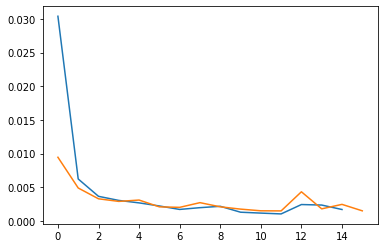

In [25]:
#plot the losses

plt.plot(losses_train)
plt.plot(losses_valid)

This part is for validation of the best model:

In [9]:
#loading the network from file, which should corespond to the checkpoint that had the highest IoU during training

net = fcn_resnet50(pretrained = False, num_classes = 1)
net = net.cuda()
net = net.eval()
checkpoint = torch.load("checkpoint_fcn_trained.pth")
net.load_state_dict(checkpoint)
torch.set_grad_enabled(False)


In [10]:
#running validation

criterion = nn.BCEWithLogitsLoss().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.0005)

train_model(net, criterion, optimizer, num_epochs=1, validation=True)

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 0/0
----------
Starting phase:  val


100%|██████████| 63/63 [00:08<00:00,  7.29it/s]


val Loss: 0.0015 Iou: 0.8406 precision:0.9880 recall:0.9633
Training complete in 0m 10s


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

  0%|          | 0/63 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/63 [00:00<?, ?it/s]

0.9412073490813648 1.0 1.0
0.6699029126213593 0.5 1.0
0.5280830280830281 1.0 1.0
0.889044289044289 1.0 1.0


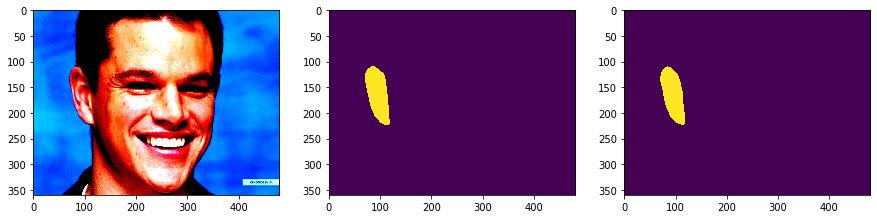

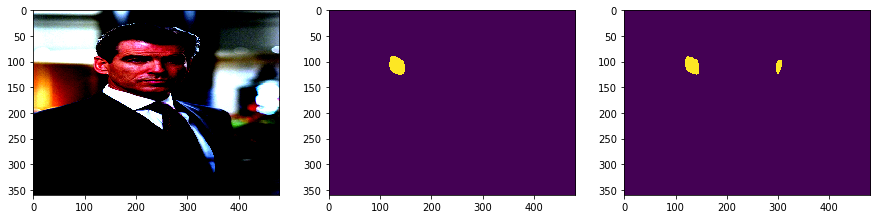

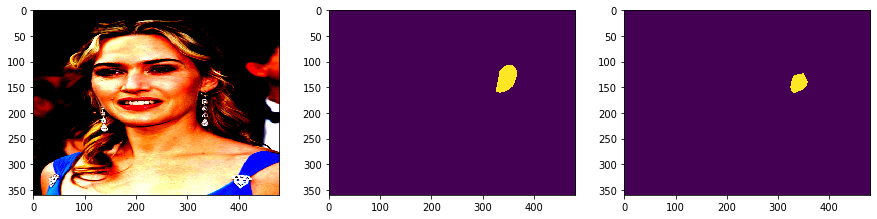

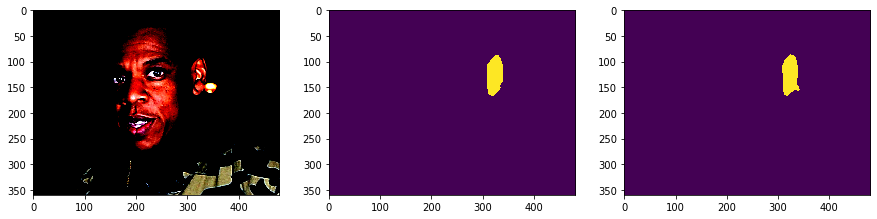

In [28]:
#running the model on a random batch of images from the dataset and displaying the results. First segmentation map
#is the annotation, second is the prediction

for images, annots in tqdm(dataset_loader_valid):
    out = net(images.cuda())["out"]
    for i in range(out.shape[0]):
        #print(annots[i].shape, images[i].shape,annots[i].cpu().detach().permute(1,2,0).numpy().shape)
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.imshow(images[i].cpu().detach().permute(1,2,0).numpy())
        ann = annots[i].cpu().detach().permute(1,2,0).numpy()[:,:,0]
        ann = ann > 0.5
        pred = (out[i].cpu().sigmoid().detach().permute(1,2,0).numpy())[:,:,0]
        pred = pred > 0.5
        plt.subplot(1,3,2)
        plt.imshow(ann)
        plt.subplot(1,3,3)
        plt.imshow(pred)
        #print(np.max(out[i].cpu().sigmoid().detach().permute(1,2,0).numpy()),np.min(out[i].cpu().detach().permute(1,2,0).numpy()))
        #print(pred.dtype,ann.dtype)
        jac, pr, re = IoU(pred,ann)
        print(jac, pr, re)
        #cv2.waitKey(0)
    break
        